# HW6 due 5p Fri Nov 19

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your submission (e.g. the .ipynb file).

You are welcome to consult websites, textbooks, and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file).

**Important:** before you do any work in the Colaboratory notebook, click "File -> Save a copy in Drive ..." and rename the file to something memorable.


# 0. [Nakseung Choi]; [He/Him/His]

a. Approximately how many hours did you spend on this assignment?

b. Were there specific problems that took much longer than others?

c. What class meeting(s) did you participate in this week?

d. What timezone(s) were you working in this week?

In [2]:
# import useful python packages
!pip install control
import numpy as np
import pylab as plt
from control import place as place

     |████████████████████████████████| 339 kB 5.0 MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344928 sha256=90928651e25fa8abc35faa64144e83710cc02183b81e7476e4af973353e8a20f
  Stored in directory: /root/.cache/pip/wheels/5b/64/54/70faad181d7baff1184541ca00c9a2efa633acd0a811831d30
Successfully built control


In [3]:
# "magic" commands, prefaced with "%", changes settings in the notebook

# this ensures plots are embedded in notebook web page
%matplotlib inline

# pdb = Python debugger, so this command turns the debugger OFF
%pdb off

Automatic pdb calling has been turned OFF


In [4]:
# numpy = numerical Python, implements arrays (/ matrices)
import numpy as np
# limit number of decimal places printed for floating-point numbers
np.set_printoptions(precision=3)

# scipy = scientific Python, implements operations on arrays / matrices
import scipy as sp
# linalg = linear algebra, implements eigenvalues, matrix inverse, etc
from scipy import linalg as la
# optimize = optimization, root finding, etc
from scipy import optimize as op

# produce matlab-style plots
import matplotlib as mpl
# increase font size on plots
mpl.rc('font',**{'size':18})
# use LaTeX to render symbols
mpl.rc('text',usetex=False)
# render animation
mpl.rc('animation',html='html5')
# animation
from matplotlib import animation as ani
# Matlab-style plotting
import matplotlib.pyplot as plt

# symbolic computation, i.e. computer algebra (like Mathematica, Wolfram Alpha)
import sympy as sym

In [5]:
# os = operating system; access OS-level commands
# e.g. create directory, delete file, execute command
# (more platform-independent than "!")
import os

In [6]:
def Jacobian(g,y,d=1e-4):
  """
  approximate derivative via finite-central-differences 

  input:
    g - function - g : R^n -> R^m
    y - n array
    (optional)
    d - scalar - finite differences displacement parameter

  output:
    Dg(y) - m x n - approximation of Jacobian of g at y
  """
  # given $g:\mathbb{R}^n\rightarrow\mathbb{R}^m$:
  # $$D_y g(y)e_j \approx \frac{1}{2\delta}(g(y+\delta e_j) - g(y - \delta e_j)),\ \delta\ll 1$$
  e = np.identity(len(y))
  Dyg = []
  for j in range(len(y)):
      Dyg.append((.5/d)*(g(y+d*e[j]) - g(y-d*e[j])))
  return np.array(Dyg).T

def numerical_simulation(f,t,x,t0=0.,dt=1e-4,ut=None,ux=None,utx=None,return_u=False):
  """
  simulate x' = f(x,u) 

  input:
    f : R x X x U --> X - vector field
      X - state space (must be vector space)
      U - control input set
    t - scalar - final simulation time
    x - initial condition; element of X

    (optional:)
    t0 - scalar - initial simulation time
    dt - scalar - stepsize parameter
    return_u - bool - whether to return u_

    (only one of:)
    ut : R --> U
    ux : X --> U
    utx : R x X --> U

  output:
    t_ - N array - time trajectory
    x_ - N x X array - state trajectory
    (if return_u:)
    u_ - N x U array - state trajectory
  """
  t_,x_,u_ = [t0],[x],[]
  
  inputs = sum([1 if u is not None else 0 for u in [ut,ux,utx]])
  assert inputs <= 1, "more than one of ut,ux,utx defined"

  if inputs == 0:
    assert not return_u, "no input supplied"
  else:
    if ut is not None:
      u = lambda t,x : ut(t)
    elif ux is not None:
      u = lambda t,x : ux(x)
    elif utx is not None:
      u = lambda t,x : utx(t,x)

  while t_[-1]+dt < t:
    if inputs == 0:
      _t,_x = t_[-1],x_[-1]
      dx = f(t_[-1],x_[-1]) * dt
    else:
      _t,_x,_u = t_[-1],x_[-1],u(t_[-1],x_[-1])
      dx = f(_t,_x,_u) * dt
      u_.append( _u )

    x_.append( _x + dx )
    t_.append( _t + dt )

  if return_u:
    return np.asarray(t_),np.asarray(x_),np.asarray(u_)
  else:
    return np.asarray(t_),np.asarray(x_)

# 1. spring-mass-damper a deux redux
Consider the following spring-mass-damper system from hw3:
![spring-mass](http://faculty.washington.edu/sburden/447/447-hw1-spring-mass.png)
The input to this system is the sinusoidal motion of the end of rightmost spring. 
Applying Newton's laws to determine the forces acting on both masses, we find two coupled second-order DE that model the system's dynamics:

$$ m\ddot{q}_1 = - c \dot{q}_1 - k q_1 + k (q_2 - q_1), $$

$$ m\ddot{q}_2 = - c \dot{q}_2 + k (u - q_2) - k (q_2 - q_1). $$

Defining $x = (q_1, \dot{q}_1, q_2, \dot{q}_2)$, we can transcribe the two coupled second-order DE obtained above into one first-order DE in matrix/vector form $\dot{x} = A x + B u$:

$$ \dot{x} = \left[ \begin{matrix} \dot{q}_1 \\ \ddot{q}_1 \\ \dot{q_2} \\ \ddot{q_2} \end{matrix} \right] = \left[ \begin{matrix} 0 & 1 & 0 & 0 \\ -\frac{2k}{m} & -\frac{c}{m}& +\frac{k}{m}  & 0 \\ 0 & 0 & 0 & 1 \\ +\frac{k}{m} & 0 & - \frac{2k}{m} & -\frac{c}{m} \end{matrix} \right] \left[ \begin{matrix} {q}_1 \\ \dot{q}_1 \\ {q_2} \\ \dot{q_2} \end{matrix} \right] + \left[ \begin{matrix} 0 \\ 0 \\ 0 \\ \frac{k}{m} \end{matrix} \right] u = A x + B u. $$

Consider the alternative choice of state vector $z = (p_1,\dot{p}_1,p_2,\dot{p}_2)$ where $p_1 = \frac{1}{2}(q_1 + q_2)$, $p_2 = \frac{1}{2} (q_1 - q_2)$.  

a. Determine the matrix $T\in\mathbb{R}^{4\times 4}$ such that $z = T x$.

$$z=\left[ \begin{matrix} p_1 \\ \dot{p_1} \\ p_2 \\ \dot{p_2} \end{matrix} \right] = \left[ \begin{matrix} 1/2(q_1+q_2) \\ 1/2(\dot{q_1}+\dot{q_2})\\ 1/2(q_1-q_2) \\ 1/2(\dot{q_1}-\dot{q_2}) \end{matrix} \right] = Tx =T\left[ \begin{matrix} q_1 \\ \dot{q_1} \\ q_2 \\ \dot{q_2} \end{matrix} \right]$$

$$\fbox{$T=\left[ \begin{matrix} 1/2 & 0 & 1/2 & 0 \\ 0 & 1/2 & 0 & 1/2 \\ 1/2 & 0 & -1/2 & 0 \\ 0 & 1/2 & 0 & -1/2 \end{matrix} \right] $}$$


b. Determine the matrix $T^{-1}\in\mathbb{R}^{4\times 4}$ such that $x = T^{-1} z$.  (***Hint:*** solve the equations $p_1 = \frac{1}{2}(q_1 + q_2)$, $p_2 = \frac{1}{2} (q_1 - q_2)$ for $q_1$ and $q_2$ in terms of $p_1$ and $p_2$.)

$$p_1=\frac{1}{2}(q_1+q_2) \Leftrightarrow q_2 = p_1-p_2$$

$$p_2 =\frac{1}{2}(q_1-q_2) \Leftrightarrow q_1 = 2p_2 + q_2 = p_2 + p_1$$

$$\dot{p_1}, \dot{p_2}$$

$$\dot{q_1}=\dot{p_2}+\dot{p_1}, \dot{q_2} = \dot{p_1}-\dot{p_2}$$

$$x=T^{-1}z$$ 

$$\fbox{$T^{-1}=\left[\begin{matrix} 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{matrix}\right]$}$$

c. Compute $\widetilde{A} = T A T^{-1}$, $\widetilde{B} = T B$ and verify that $\dot{z} = \widetilde{A} z + \widetilde{B} u$ by comparing with the solution to problem (1d.) from homework 3.

$$\widetilde{A} = T A T^{-1} = \left[ \begin{matrix} 1/2 & 0 & 1/2 & 0 \\ 0 & 1/2 & 0 & 1/2 \\ 1/2 & 0 & -1/2 & 0 \\ 0 & 1/2 & 0 & -1/2 \end{matrix} \right]\left[ \begin{matrix} 0 & 1 & 0 & 0 \\ -\frac{2k}{m} & -\frac{c}{m}& +\frac{k}{m}  & 0 \\ 0 & 0 & 0 & 1 \\ +\frac{k}{m} & 0 & - \frac{2k}{m} & -\frac{c}{m} \end{matrix} \right]\left[\begin{matrix} 1 & 0 & 1 & 0 \\ 0 & 1 & 0 & 1 \\ 1 & 0 & -1 & 0 \\ 0 & 1 & 0 & -1\end{matrix}\right] $$

$$\widetilde{A} = \left[\begin{matrix} 0 & 1 & 0 & 0 \\ -k/m & -c/m & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -3k/m & -c/m \end{matrix}\right]$$

$$\widetilde{B} = TB = \left[ \begin{matrix} 1/2 & 0 & 1/2 & 0 \\ 0 & 1/2 & 0 & 1/2 \\ 1/2 & 0 & -1/2 & 0 \\ 0 & 1/2 & 0 & -1/2 \end{matrix} \right] \left[ \begin{matrix} 0 \\ 0 \\ 0 \\ \frac{k}{m} \end{matrix} \right]$$

$$\widetilde{B} = \left[ \begin{matrix} 0 \\ \frac{k}{2m} \\ 0 \\ -\frac{k}{2m} \end{matrix} \right]$$

$$\dot{z}=\widetilde{A}z+\widetilde{B}u$$ 

$$\dot{z} = \left[ \begin{matrix} \dot{p_1} \\ \ddot{p_1} \\ \dot{p_2} \\ \ddot{p_2} \end{matrix} \right]$$

$$\dot{z}=\widetilde{A}z+\widetilde{B}u = \left[\begin{matrix} 0 & 1 & 0 & 0 \\ -k/m & -c/m & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -3k/m & -c/m \end{matrix}\right]\left[ \begin{matrix} z_1 \\ \dot{z}_1 \\ z_2 \\ \dot{z}_2 \end{matrix} \right]+\left[ \begin{matrix} 0 \\ \frac{k}{2m} \\ 0 \\ -\frac{k}{2m} \end{matrix} \right]u$$

d. Verify that $A$ has the same eigenvalues as $\widetilde{A}$ using parameters $m = 250$, $k = 50$, $c = 10$.

$$\widetilde{A} = \left[\begin{matrix} 0 & 1 & 0 & 0 \\ -1/5 & -1/25 & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -3/5 & -1/25 \end{matrix}\right]$$  

$$A=\left[ \begin{matrix} 0 & 1 & 0 & 0 \\ -2/5 & -1/25& 1/5  & 0 \\ 0 & 0 & 0 & 1 \\ 1/5 & 0 & -2/5 & -1/25 \end{matrix} \right]$$

$$\lambda = -0.02\pm 0.774338j, -0.02\pm 0.446766j$$

***Takeaway:***  a linear system's dynamics can be represented using different choices of state variables (also termed ***coordinates***), which changes the 
$``A"$
and 
$``B"$
matrices.  However, the eigenvalues of the $A$'s -- hence, the system's stability properties -- aren't affected by the change-of-coordinates (also termed a ***similarity transform***).

# 2. state and output feedback

***Purpose:*** apply analytical and computational techniques to observe and control the state of a system.

Consider the following model of a robot arm that consists of a rigid rod of length $\ell$ attached to a point mass $m$ at one end and a rotational joint at the other end,

$$ \ m \ell^2 \ddot{\theta} = m g \ell \sin\theta - \gamma\dot{\theta} + \tau, $$

where 
$\gamma$ is a coefficient of friction for the rotational joint 
and 
$\tau$ is a torque applied by a motor attached to the rotational joint.

With state $x = (\theta,\dot{\theta})$ and input $u = \tau$, linearizing the dynamics around the vertical equilibrium $x_e = (\theta_e,\dot{\theta}_e) = (0,0)$, $u_e = \tau_e = 0$ yields the linear control system

$$ \dot{\delta x} = A \delta x + B \delta u $$

where $x \approx x_e + \delta x$, $u \approx u_e + \delta u$,

$$
A = \left[\begin{matrix} 0 & 1 \\ \frac{g}{\ell} & -\frac{\gamma}{m\ell^2} \end{matrix}\right], \ 
B = \left[\begin{matrix} 0 \\ \frac{1}{m\ell^2} \end{matrix}\right].
$$

a. Design a linear state-feedback law $\delta u = - K \delta x$ that gives a closed-loop characteristic polynomial $s^2 + 2\zeta\omega s + \omega^2$ that corresponds to a second-order system that is ***overdamped*** ($\zeta = 3/2$) and has ***natural frequency*** $\omega = 2$Hz.

$$BK = \left[\begin{matrix} 0 \\ \frac{1}{m\ell^2} \end{matrix}\right]\left[\begin{matrix} k_1 & k_2 \end{matrix}\right] = \left[\begin{matrix} 0 & 0 \\ \frac{k_1}{m\ell^2} & \frac{k_2}{m\ell^2} \end{matrix}\right]$$

$$a(s)=det(sI-(A-BK))=det(\left[\begin{matrix} s & 0 \\ 0 & s\end{matrix}\right] - \left[\begin{matrix} 0 & 1 \\ \frac{g}{\ell}-\frac{k_1}{m\ell^2} & -\frac{\gamma+k_2}{m\ell^2} \end{matrix}\right]) = \left[\begin{matrix} s & -1 \\ -\frac{g}{\ell}+\frac{k_1}{m\ell^2} & s+\frac{\gamma+k_2}{m\ell^2} \end{matrix}\right])$$

$$det(\left[\begin{matrix} a & b \\ c & d\end{matrix}\right]) = ad-bc$$ 

$$a(s) = s^2+\frac{\gamma+k_2}{m\ell^2}s-(\frac{g}{\ell}-\frac{k_1}{m\ell^2})$$

$$s^2 + 2\zeta\omega s + \omega^2$$

$$\omega^2=-(\frac{g}{\ell}-\frac{k_1}{m\ell^2}) \Leftrightarrow \fbox{$k_1=m\ell g + \omega^2 m\ell^2 = m\ell g + 4 m\ell^2$}$$

$$\frac{\gamma+k_2}{m\ell^2}=2\zeta\omega \Leftrightarrow \fbox{$k_2=2\zeta\omega m \ell^2-\gamma=6m\ell^2-\gamma$}$$

b. Verify that the `ctrl.place` command gives the same answer as (a.) when you use parameter values $m = 1$ kg, $\ell = 1$ m, $g = 9.81$ m/sec/sec, $\gamma = 1$.

$$K_1 = m\ell g+4m\ell^2 = 13.81$$

$$K_2 = 6m\ell^2-\gamma = 5$$

$$\lambda^2 + 6\lambda +4 = 0$$

$$\lambda_1 = -0.76393,\ \lambda_2 = -5.236$$

**Please croll down for the solution.**

c. Implement a simulation of the closed-loop system using parameter values from (b.) to verify that the closed-loop dynamics are as expected.

**Please scroll down for the solution.**

Now suppose you have to control the system using a distance sensor attached to the mass so that the output is

$$ y = \ell\sin\theta. $$

d. Linearize the output equation at the vertical equilibrium, that is, evaluate 

$$ C = \left.\frac{\partial y}{\partial x} \right|_{x_e,u_e},\ D = \left.\frac{\partial y}{\partial u} \right|_{x_e,u_e} $$


$$C = \frac{\partial y}{\partial x}|_{x=x_e, u=u_e}=\left[\begin{matrix}\ell cos\theta & 0 \end{matrix}\right],\ \  \frac{\partial y}{\partial x}|_{x=x_e, u=u_e} = \left[\begin{matrix}\ell  & 0 \end{matrix}\right]$$

$$$D = \frac{\partial y}{\partial u}|_{x=x_e, u=u_e}=0$$


so that $y \approx \delta y = C \delta x + D \delta u$ near the equilibrium.

e. Design a linear observer

$$ \dot{\delta\widehat{x}} = A \delta\widehat{x} + B \delta u - L(\delta y - \delta\widehat{y}),\ \delta\widehat{y} = C \delta\widehat{x} + D \delta u $$

so that the error dynamics $\dot{e} = (A + LC) e$ has characteristic polynomial $s^2 + 2\xi\sigma s + \sigma^2$ that corresponds to a second-order system that is ***underdamped*** ($\xi = 1/2$) and has ***natural frequency*** $\sigma = 10$Hz



$$a(s)=det(sI-(A+LC))$$

First compute $LC$ where $L=\left[\begin{matrix} l_1 \\ l_2 \end{matrix}\right]$

$$LC = \left[\begin{matrix} l_1 \\ l_2 \end{matrix}\right]\left[\begin{matrix} l & 0 \end{matrix}\right] = \left[\begin{matrix} ll_1 & 0 \\ ll_2 & 0 \end{matrix}\right]$$

$$a(s)=det(sI-(A+LC))= det(\left[\begin{matrix} s & 0 \\ 0 & s \end{matrix}\right] - (\left[\begin{matrix} 0 & 1 \\ \frac{g}{\ell} & -\frac{\gamma}{m\ell^2} \end{matrix}\right] + \left[\begin{matrix} \ell l_1 & 0 \\ \ell l_2 & 0 \end{matrix}\right])) = det(\left[\begin{matrix} s & 0 \\ 0 & s\end{matrix}\right] - \left[\begin{matrix} \ell l_1 & 1 \\ \frac{g}{l} + \ell l_2 & - \frac{\gamma}{m\ell^2} \end{matrix}\right]) = det(\left[\begin{matrix} s - \ell l_1 & -1 \\ -\frac{g}{\ell} - \ell l_2 & s + \frac{\gamma}{m\ell^2} \end{matrix}\right])$$

$$det(\left[\begin{matrix} a & b \\ c & d\end{matrix}\right]) = ad-bc$$

$$a(s) = s^2 + (\frac{\gamma}{m\ell^2}- \ell l_1)s - (\frac{\gamma l_1}{m\ell} + \frac{g}{\ell} + \ell l_2)$$

$$s^2 + 2\xi\sigma s + \sigma^2$$ 

$$2\xi\sigma = \frac{\gamma}{m\ell^2} - \ell l_1 \Leftrightarrow \fbox{$l_1 = \frac{\gamma}{m\ell^3} - \frac{10}{\ell}$}$$

$$\sigma^2 = -(\frac{\gamma l_1}{m\ell} + \frac{g}{\ell} + \ell l_2)\Leftrightarrow \fbox{$l_2 = \frac{100}{\ell} + \frac{\gamma}{m \ell^2} (\frac{\gamma}{m\ell^3} - \frac{10}{\ell}) + \frac{g}{\ell^2}$}$$

f. Verify that the `ctrl.place` command gives the same answer as (d.) when you use parameter values from (b.).

(***Note:*** when using `ctrl.place` to design an observer, you must transpose the $A$ and $B$ matrices and negate and transpose the result: `L = -ctrl.place(A.T,C.T,roots).T`.)

**Please scroll down for the solution.**

g. Implement a simulation of the observer system using parameter values from (b.) to verify that the error dynamics are as expected when the real system is at equilibrium (i.e. $\delta x = 0$, $\delta u = 0$).

**Please scroll down for the solution.**

h. Implement a simulation where you use the observer from (g.) to obtain the state estimate $\delta\widehat{x}$ that you then use in the controller from (c.) to simultaneously control the observer and system.

**Please scroll down for the solution.**

***Bonus:*** Implement a simulation where you apply the observer from (g.)  and controller from (c.) to the ***nonlinear*** system (nonlinear dynamics and nonlinear output equation).

In [8]:
# Solution for 2 b.

m = 1 
l = 1 
g = 9.81 
gamma = 1 

A = np.asarray([[0,1],[g/l, -gamma/(m*l**2)]])

B = np.asarray([[0],[1/(m*l**2)]])

# Put Eigenvalues as p lambda1 = -0.76393 lambda2 = -5.236

p = [-0.76393, -5.236] 
K = place(A,B,p)
print(K)

[[13.81  5.  ]]


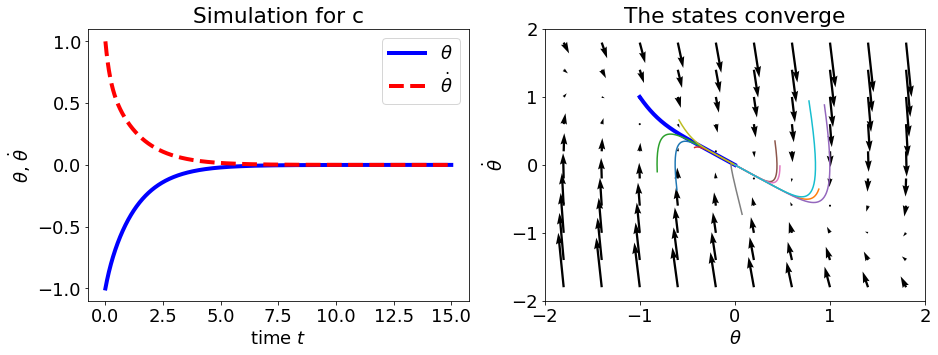

In [9]:
# Solution for 2 c.

AA = A-np.multiply(B,K)
v,w = np.linalg.eig(AA) ## eigenvalues

def f_LTI(t,x,u):
    x1,x2 = x # charge, current
    return np.dot(x,AA.T)

plt.figure(figsize=(15,5))
dt = 1e-2
x10,x20 = (-1.,1.)
x0 = np.array([x10,x20])

t = 15

t_,x_ = numerical_simulation(f_LTI,t,x0,dt=dt,ut=lambda t : 0)
q_,dq_ = x_[:,0],x_[:,1]

ax = plt.subplot(1,2,1)
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'$\theta$, $\dot{\theta}$')
plt.plot(t_,q_,'b',lw=4,label=r'$\theta$')
plt.plot(t_,dq_,'r--',lw=4,label=r'$\dot{\theta}$')
plt.legend()
plt.title('Simulation for c')

ax = plt.subplot(1,2,2)
Q, Qd = np.meshgrid(np.linspace(-1.8,+1.8, 10), np.linspace(-1.8, +1.8, 10))
dQ,dQd = np.asarray([f_LTI(0.,(q,dq),0.).flatten() for q,dq in zip(Q.flatten(),Qd.flatten())]).T
dQ,dQd = dQ.reshape(dQ.shape),dQd.reshape(Qd.shape)
ax.quiver(Q,Qd,dQ,dQd)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\dot{\theta}$')
ax.set_ylim((-2,2))
ax.set_xlim((-2,2))
ax.plot(q_,dq_,'b',lw=4)
plt.title('The states converge')

for _ in range(10):
  
  x0 = 2*(np.random.rand(2) - .5)
  t_,x_ = numerical_simulation(f_LTI,t,x0,dt=dt,ut=lambda t : 0)
  q_,dq_ = x_[:,0],x_[:,1]
  ax.plot(q_,dq_)
  


In [10]:
# Solution for 2 f.

m = 1 
l = 1 
g = 9.81 
gamma = 1 

A = np.asarray([[0,1],[g/l, -gamma/(m*l**2)]])
B = np.asarray([[0],[1/(m*l**2)]])
C = np.asarray([[l, 0]])
D = np.asarray([[0]])
eigen = [-5+8.66*1j, -5-8.66*1j]

L = -place(A.T,C.T,eigen).T
print('L found using ctrl.place package:')
print(L)


L found using ctrl.place package:
[[  -9.   ]
 [-100.806]]


[-5.+8.66j -5.-8.66j]


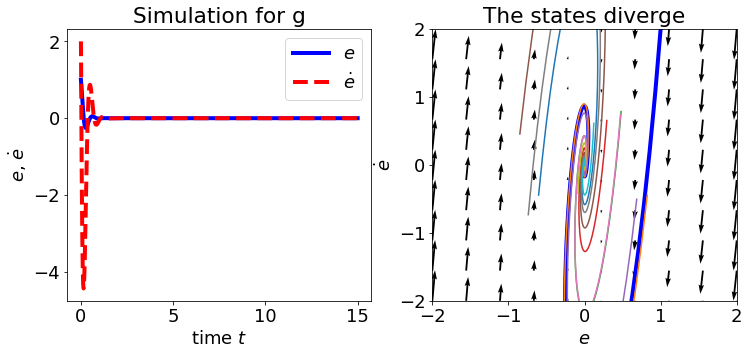

In [17]:
# Solution for 2 g.

AA = A+np.multiply(L,C)
v,w = np.linalg.eig(AA)
print(v)

def obs_LTI(t,e,u):
    e1,e2 = e # charge, current
    return np.dot(e,AA.T)

plt.figure(figsize=(12,5))
dt = 1e-2
e10,e20 = (1.,2.)
e0 = np.array([e10,e20])
t = 15

t_,e_ = numerical_simulation(obs_LTI,t,e0,dt=dt,ut=lambda t : 0)
e_,de_ = e_[:,0],e_[:,1]

ax = plt.subplot(1,2,1)
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'$e$, $\dot{e}$')
plt.plot(t_,e_,'b',lw=4,label=r'$e$')
plt.plot(t_,de_,'r--',lw=4,label=r'$\dot{e}$')
plt.legend()
plt.title('Simulation for g')

ax = plt.subplot(1,2,2)
e, ed = np.meshgrid(np.linspace(-2,+2, 10), np.linspace(-2, +2, 10))
de,ded = np.asarray([obs_LTI(0.,(e,de),0.).flatten() for e,de in zip(e.flatten(),ed.flatten())]).T
de,ded = de.reshape(de.shape),ded.reshape(ed.shape)
ax.quiver(e,ed,de,ded)
ax.set_xlabel(r'$e$')
ax.set_ylabel(r'$\dot{e}$')
ax.set_ylim((-2,2))
ax.set_xlim((-2,2))
ax.plot(e_,de_,'b',lw=4)
plt.title('The states converge')

for _ in range(10):
  e0 = 2*(np.random.rand(2) - .5)
  t_,e_ = numerical_simulation(obs_LTI,t,e0,dt=dt,ut=lambda t : 0)
  e_,de_ = e_[:,0],e_[:,1]
  ax.plot(e_,de_)
  

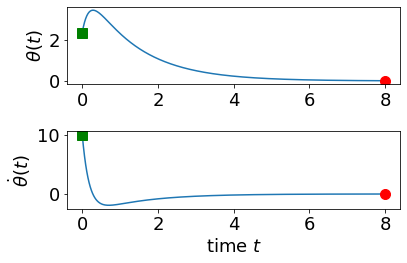

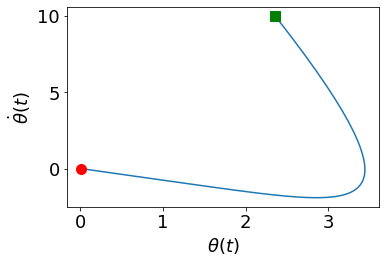

In [19]:
# Solution for 2 h.

def f_LTI(t,x,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-BK)
  return np.dot(x,(A-np.dot(B,K)).T)

# simulation duration, timestep
T = 8.
dt = 1e-2

# non-zero initial state
theta0 = 3*np.pi/4
dtheta0 = 10.
x0 = np.array([theta0,dtheta0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : 0.

# numerical simulation returns:
# t_ - size N array
# x_ - size N x 2 array (since the state is 2-dimensional)
t_,x_ = numerical_simulation(f_LTI,T,x0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
theta_,dtheta_ = x_[:,0],x_[:,1]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,theta_,label='(Linear)')
plt.plot(t_[0],theta_[0],'gs',ms=10)
plt.plot(t_[-1],theta_[-1],'ro',ms=10)
plt.ylabel(r'$\theta(t)$')

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,dtheta_,label='(Linear)')
plt.plot(t_[0],dtheta_[0],'gs',ms=10)
plt.plot(t_[-1],dtheta_[-1],'ro',ms=10)
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'time $t$')

plt.tight_layout();

# phase portrait
plt.figure()
plt.subplot(1,1,1)
plt.plot(theta_,dtheta_,label='(Linear)')
plt.plot(theta_[0],dtheta_[0],'gs',ms=10)
plt.plot(theta_[-1],dtheta_[-1],'ro',ms=10)
plt.ylabel(r'$\dot{\theta}(t)$')
plt.xlabel(r'${\theta}(t)$')

plt.tight_layout();

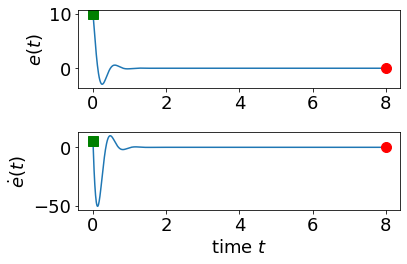

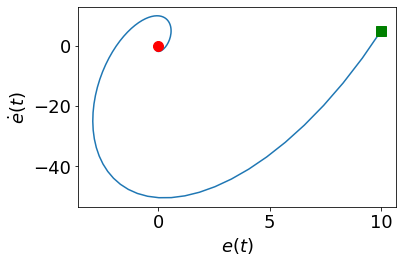

In [20]:
# solution for 2 h. 


def f_error(t,e,u):
  # x is a 1-D array, i.e. a "row", so we left-multiply the transpose of (A-LC)
  return np.dot(e,(A+np.dot(L,C)).T)

# non-zero initial state
error0 = 10.
derror0 = 5.
e0 = np.array([error0,derror0])

# zero input
def u(t):
  ut = 0
  return ut
# this could equivalently be written in one line:
# u = lambda t : np.sin(t)

# numerical simulation returns:
# t_ - size N array
# e_ - size N x 2 array (since the state is 2-dimensional)
t_,e_ = numerical_simulation(f_error,T,e0,ut=u,dt=dt)

# the first column contains theta(t), the second column contains dtheta(t)
# (I append an underscore "_" to remind myself these are time series)
error_,derror_ = e_[:,0],e_[:,1]

# we'll use the Matplotlib library for plots
# (as the name suggests, it has a similar interface to MATLAB)
import pylab as plt

# plot theta
plt.figure()
plt.subplot(2,1,1)
plt.plot(t_,error_,label='(Linear)')
plt.plot(t_[0],error_[0],'gs',ms=10)
plt.plot(t_[-1],error_[-1],'ro',ms=10)
plt.ylabel(r'$e(t)$')

# plot dtheta
plt.subplot(2,1,2)
plt.plot(t_,derror_,label='(Linear)')
plt.plot(t_[0],derror_[0],'gs',ms=10)
plt.plot(t_[-1],derror_[-1],'ro',ms=10)
plt.ylabel(r'$\dot{e}(t)$')
plt.xlabel(r'time $t$')

plt.tight_layout();

# phase portrait
plt.figure()
plt.subplot(1,1,1)
plt.plot(error_,derror_,label='(Linear)')
plt.plot(error_[0],derror_[0],'gs',ms=10)
plt.plot(error_[-1],derror_[-1],'ro',ms=10)
plt.ylabel(r'$\dot{e}(t)$')
plt.xlabel(r'$e(t)$');

plt.tight_layout();